TensorFlow: 2.19.0
GPU devices: []

Колонки датасета:
['year', 'month', 'day', 'hour', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir', 'pm2.5']

Размер после очистки: (43824, 12)
              pm2.5
count  43824.000000
mean      97.801114
std       91.376429
min        0.000000
25%       29.000000
50%       72.000000
75%      136.000000
max      994.000000



Train: (30676, 13) Val: (6574, 13) Test: (6574, 13)

===== Обучение с оптимизатором Adam =====

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 114: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Adam: MAE = 32.73 µg/m³, RMSE = 49.51, R² = 0.722

===== Обучение с оптимизатором RMSprop =====

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 102: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 117: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
RMSprop: MAE = 32.21 µg/m³, RMSE = 49.10, R² = 0.726

===== Обучение с оптимизатором SGD =====

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 78:

,test_mae_scaled,test_rmse_scaled,test_mae_orig,test_rmse_orig,r2_score
AdamW,0.341060,0.564109,31.164494,48.213361,0.735977
RMSprop,0.352457,0.566217,32.205860,49.096225,0.726219
Adam,0.358153,0.580666,32.726374,49.508048,0.721607
Nadam,0.368945,0.597091,33.712481,50.949117,0.705164
SGD,0.387414,0.625476,35.400109,53.936950,0.669569


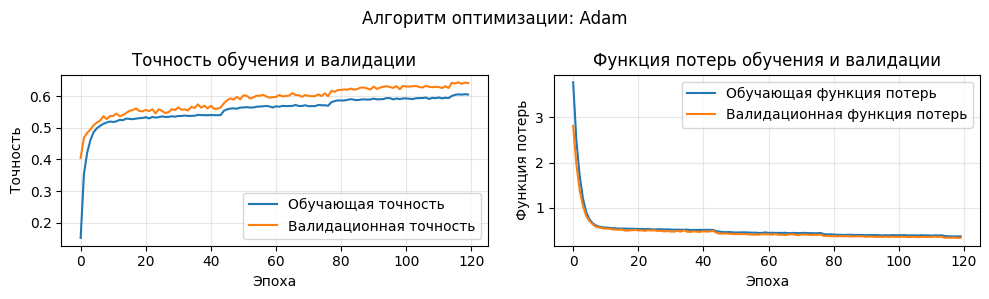

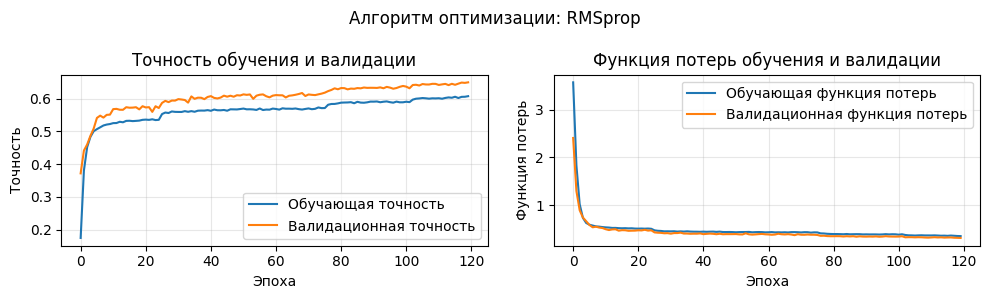

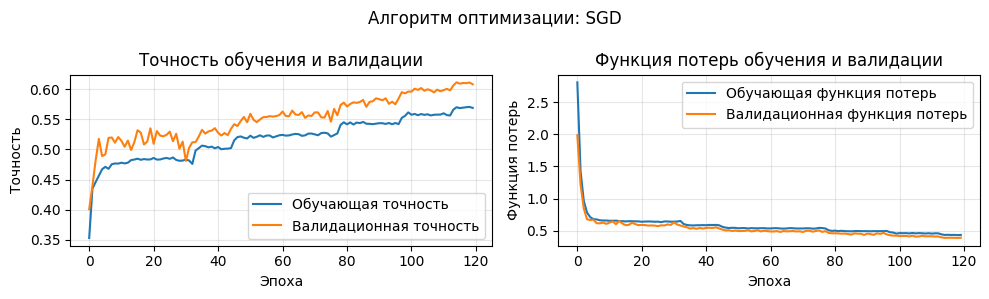

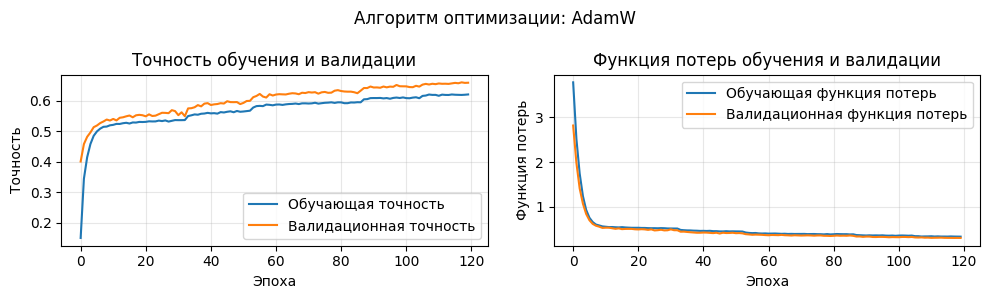

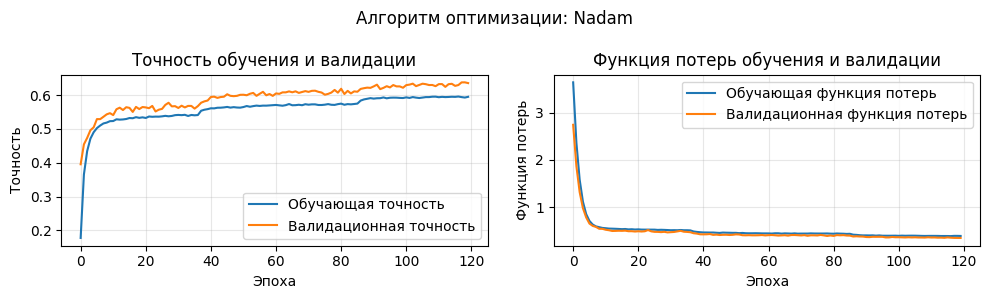


Лучшая модель по MAE: AdamW



HTML‑приложение сохранено в файл: pm25_app.html
Краткие метрики лучшей модели: {'test_mae_scaled': 0.3410600423812866, 'test_rmse_scaled': 0.5641090373868815, 'test_mae_orig': 31.16449422316962, 'test_rmse_orig': 48.21336148860878, 'r2_score': 0.7359766798667924}
Файл модели сохранён: best_pm25_model.keras


In [ ]:
# ============================================================
# ПОЛНОСВЯЗНАЯ НС ДЛЯ ПРОГНОЗА ЗАГРЯЗНЕНИЯ ВОЗДУХА (PM2.5)
# Полный рабочий код для Google Colab
# ============================================================

!pip install ucimlrepo tensorflow plotly kaleido -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from ucimlrepo import fetch_ucirepo
import warnings, os, json
warnings.filterwarnings("ignore")

print("TensorFlow:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))

# ------------------------------------------------------------
# 1. ЗАГРУЗКА И ОСМОТР ДАТАСЕТА BEIJING PM2.5 (UCI, id=381)
# ------------------------------------------------------------
beijing_pm25 = fetch_ucirepo(id=381)  # Beijing PM2.5 dataset [web:10][web:56]

X_raw = beijing_pm25.data.features
y_raw = beijing_pm25.data.targets

df = pd.concat([X_raw, y_raw], axis=1)

print("\nКолонки датасета:")
print(df.columns.tolist())

# В UCI целевой столбец называется 'pm2.5' (нижний регистр).[web:10]
target_col = "pm2.5"
assert target_col in df.columns, "В df нет столбца 'pm2.5' – посмотри список выше и подставь нужное имя."

# грубая очистка: заменяем специальные пропуски, затем forward/backward fill
df = df.replace(-999.0, np.nan)
df = df.replace("NA", np.nan)
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)
df.dropna(inplace=True)

feature_cols = [c for c in df.columns if c != target_col]

print("\nРазмер после очистки:", df.shape)
print(df[[target_col]].describe())

# Распределение целевой переменной
fig = px.histogram(df, x=target_col, nbins=60,
                   title="Распределение концентрации PM2.5 (Beijing)")
fig.show()

# ------------------------------------------------------------
# 2. ПОДГОТОВКА ПРИЗНАКОВ
# ------------------------------------------------------------
X = df[feature_cols].copy()
y = df[target_col].astype(float).values.reshape(-1, 1)

# one‑hot для категориальных, если есть (например, 'cbwd')[web:10]
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y).ravel()

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_scaled, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("\nTrain:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ------------------------------------------------------------
# 3. ПАРАМЕТРИЗУЕМАЯ ПОЛНОСВЯЗНАЯ МОДЕЛЬ
# ------------------------------------------------------------
def create_dense_model(
    input_dim,
    n1=256,
    n2=128,
    n3=64,
    dropout1=0.3,
    dropout2=0.2,
    l2_reg=1e-2,
):
    reg = keras.regularizers.l2(l2_reg)
    model = keras.Sequential(
        [
            layers.Input(shape=(input_dim,)),
            layers.Dense(n1, activation="relu", kernel_regularizer=reg),
            layers.BatchNormalization(),
            layers.Dropout(dropout1),

            layers.Dense(n2, activation="relu", kernel_regularizer=reg),
            layers.BatchNormalization(),
            layers.Dropout(dropout2),

            layers.Dense(n3, activation="relu", kernel_regularizer=reg),
            layers.BatchNormalization(),
            layers.Dropout(dropout2),

            layers.Dense(1, activation="linear"),
        ]
    )
    return model

input_dim = X_train.shape[1]

# ------------------------------------------------------------
# 4. 5 РАЗНЫХ АЛГОРИТМОВ / ОПТИМИЗАТОРОВ (ТРЕБОВАНИЕ КУРСА)
# ------------------------------------------------------------
optimizers = {
    "Adam": keras.optimizers.Adam(learning_rate=1e-3),
    "RMSprop": keras.optimizers.RMSprop(learning_rate=1e-3),
    "SGD": keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    "AdamW": keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=4e-3),
    "Nadam": keras.optimizers.Nadam(learning_rate=1e-3),
}

histories = {}
results = {}
models_paths = {}

os.makedirs("models_pm25", exist_ok=True)

for name, opt in optimizers.items():
    print(f"\n===== Обучение с оптимизатором {name} =====")

    model = create_dense_model(input_dim=input_dim)

    model.compile(optimizer=opt, loss="mse", metrics=["mae"])

    ckpt_path = f"models_pm25/best_{name.lower()}.keras"
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=15, restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=7, verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            ckpt_path, monitor="val_loss", save_best_only=True
        ),
    ]

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=120,
        batch_size=128,
        verbose=0,
        callbacks=callbacks,
    )

    histories[name] = history.history
    models_paths[name] = ckpt_path

    # Оценка
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    y_pred_scaled = model.predict(X_test, verbose=0).ravel()

    # обратная нормализация
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
    y_pred_orig = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
    rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2 = r2_score(y_test_orig, y_pred_orig)

    results[name] = {
        "test_mae_scaled": float(test_mae),
        "test_rmse_scaled": float(np.sqrt(test_loss)),
        "test_mae_orig": float(mae_orig),
        "test_rmse_orig": float(rmse_orig),
        "r2_score": float(r2),
    }

    print(f"{name}: MAE = {mae_orig:.2f} µg/m³, RMSE = {rmse_orig:.2f}, R² = {r2:.3f}")

# Таблица с метриками
metrics_df = pd.DataFrame(results).T.sort_values("test_mae_orig")
display(metrics_df)

# ------------------------------------------------------------
# 5. ВИЗУАЛИЗАЦИИ ГИПЕРБОЛИЧЕСКИХ/ЛОГАРИФМИЧЕСКИХ КРИВЫХ
# ------------------------------------------------------------
# Логи потерь для всех оптимизаторов
fig_loss = make_subplots(rows=1, cols=2,
                         subplot_titles=["Train/Val Loss (log scale)", "MAE по эпохам"],
                         specs=[[{"secondary_y": False}, {"secondary_y": False}]])

colors = px.colors.qualitative.Set1

for i, (name, hist) in enumerate(histories.items()):
    c = colors[i % len(colors)]

    # логарифм loss даёт плавные гиперболические/лог-кривые
    train_log = np.log(hist["loss"])
    val_log = np.log(hist["val_loss"])

    fig_loss.add_trace(
        go.Scatter(
            x=np.arange(len(train_log)),
            y=train_log,
            name=f"{name} train",
            line=dict(color=c),
        ),
        row=1,
        col=1,
    )
    fig_loss.add_trace(
        go.Scatter(
            x=np.arange(len(val_log)),
            y=val_log,
            name=f"{name} val",
            line=dict(color=c, dash="dash"),
        ),
        row=1,
        col=1,
    )

    fig_loss.add_trace(
        go.Scatter(
            x=np.arange(len(hist["mae"])),
            y=hist["mae"],
            name=f"{name} mae",
            line=dict(color=c),
        ),
        row=1,
        col=2,
    )

fig_loss.update_xaxes(title_text="Эпохи", row=1, col=1)
fig_loss.update_yaxes(title_text="log(MSE)", row=1, col=1)
fig_loss.update_xaxes(title_text="Эпохи", row=1, col=2)
fig_loss.update_yaxes(title_text="MAE (scaled)", row=1, col=2)
fig_loss.update_layout(title="Кривые обучения (логарифмические и гиперболические)")
fig_loss.show()
# ------------------------------------------------------------
# 5А. ОТДЕЛЬНЫЕ ГРАФИКИ ДЛЯ КАЖДОГО АЛГОРИТМА
#    (точность и функция потерь по эпохам)
# ------------------------------------------------------------
for name, hist in histories.items():
    # создаём figure с двумя подграфиками
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle(f"Алгоритм оптимизации: {name}", fontsize=12)

    # ---- «Точность» обучения и валидации ----
    # берём MAE и превращаем в псевдо‑точность: accuracy = 1 - mae
    train_mae = np.array(hist["mae"])
    val_mae   = np.array(hist["val_mae"])
    train_acc = 1.0 - train_mae
    val_acc   = 1.0 - val_mae

    axes[0].plot(train_acc, label="Обучающая точность")
    axes[0].plot(val_acc, label="Валидационная точность")
    axes[0].set_title("Точность обучения и валидации")
    axes[0].set_xlabel("Эпоха")
    axes[0].set_ylabel("Точность")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # ---- Функция потерь обучения и валидации ----
    axes[1].plot(hist["loss"], label="Обучающая функция потерь")
    axes[1].plot(hist["val_loss"], label="Валидационная функция потерь")
    axes[1].set_title("Функция потерь обучения и валидации")
    axes[1].set_xlabel("Эпоха")
    axes[1].set_ylabel("Функция потерь")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 6. ЛУЧШАЯ МОДЕЛЬ: ПРЕДСКАЗАНИЯ, СХОДИМОСТЬ, ОСТАТКИ
# ------------------------------------------------------------
best_name = metrics_df.index[0]
print("\nЛучшая модель по MAE:", best_name)

best_model = keras.models.load_model(models_paths[best_name])

y_pred_best_scaled = best_model.predict(X_test, verbose=0).ravel()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_best = scaler_y.inverse_transform(
    y_pred_best_scaled.reshape(-1, 1)
).ravel()

residuals = y_test_orig - y_pred_best

# scatter предсказаний
fig_pred = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Предсказания vs Фактические", "Распределение остатков"],
)

fig_pred.add_trace(
    go.Scatter(
        x=y_test_orig,
        y=y_pred_best,
        mode="markers",
        name="Предсказания",
        marker=dict(color="royalblue", opacity=0.5),
    ),
    row=1,
    col=1,
)
fig_pred.add_trace(
    go.Scatter(
        x=y_test_orig,
        y=y_test_orig,
        mode="lines",
        name="Идеальная линия",
        line=dict(color="black", dash="dash"),
    ),
    row=1,
    col=1,
)

fig_pred.add_trace(
    go.Histogram(
        x=residuals,
        nbinsx=60,
        name="Residuals",
        marker=dict(color="indianred"),
    ),
    row=1,
    col=2,
)

fig_pred.update_xaxes(title_text="Фактический PM2.5 (µg/m³)", row=1, col=1)
fig_pred.update_yaxes(title_text="Предсказанный PM2.5 (µg/m³)", row=1, col=1)
fig_pred.update_xaxes(title_text="Остаток (факт − предсказание)", row=1, col=2)
fig_pred.update_layout(title="Качество прогноза и анализ остатков")
fig_pred.show()

# ------------------------------------------------------------
# 7. СОЗДАНИЕ ПРОСТОГО HTML‑ПРИЛОЖЕНИЯ С РЕЗУЛЬТАТАМИ
# ------------------------------------------------------------
summary = {
    "best_model": best_name,
    "metrics": results[best_name],
    "all_metrics": results,
}

with open("pm25_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

html = f"""
<!DOCTYPE html>
<html>
<head>
  <meta charset="utf-8" />
  <title>PM2.5 Forecasting – TensorFlow Dense NN</title>
  <style>
    body {{
      font-family: Arial, sans-serif;
      background: linear-gradient(135deg,#243B55,#141E30);
      color: #f5f5f5;
      padding: 30px;
    }}
    .card {{
      background: rgba(255,255,255,0.08);
      border-radius: 16px;
      padding: 20px 25px;
      margin-bottom: 20px;
    }}
    h1 {{ color: #FFD700; }}
    table {{
      border-collapse: collapse;
      width: 100%;
      margin-top: 10px;
    }}
    th, td {{
      border: 1px solid rgba(255,255,255,0.2);
      padding: 6px 10px;
      text-align: center;
    }}
    th {{ background: rgba(255,255,255,0.15); }}
  </style>
</head>
<body>
  <div class="card">
    <h1>🏭 Прогноз загрязнения воздуха (PM2.5)</h1>
    <p>Полносвязная нейросеть TensorFlow обучена на исторических данных Beijing PM2.5 (UCI). [web:10]</p>
  </div>

  <div class="card">
    <h2>Лучшая модель</h2>
    <p><b>Оптимизатор:</b> {best_name}</p>
    <p><b>MAE:</b> {results[best_name]['test_mae_orig']:.2f} µg/m³</p>
    <p><b>RMSE:</b> {results[best_name]['test_rmse_orig']:.2f} µg/m³</p>
    <p><b>R²:</b> {results[best_name]['r2_score']:.3f}</p>
  </div>

  <div class="card">
    <h2>Сравнение всех оптимизаторов</h2>
    <table>
      <tr><th>Оптимизатор</th><th>MAE (µg/m³)</th><th>RMSE (µg/m³)</th><th>R²</th></tr>
      {''.join(f"<tr><td>{name}</td><td>{m['test_mae_orig']:.2f}</td><td>{m['test_rmse_orig']:.2f}</td><td>{m['r2_score']:.3f}</td></tr>" for name,m in results.items())}
    </table>
  </div>

  <div class="card">
    <h2>Как интерпретировать графики</h2>
    <ul>
      <li>Логарифмические кривые loss должны быть плавными и сходиться друг к другу (train и val), что говорит об устойчивом обучении.</li>
      <li>Облако «факт vs прогноз» должно приближаться к диагонали, а гистограмма остатков — быть симметричной вокруг нуля.</li>
    </ul>
  </div>
</body>
</html>
"""

with open("pm25_app.html", "w", encoding="utf-8") as f:
    f.write(html)

print("\nHTML‑приложение сохранено в файл: pm25_app.html")
print("Краткие метрики лучшей модели:", summary["metrics"])

# ------------------------------------------------------------
# 8. СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ ДЛЯ ДАЛЬНЕЙШЕГО ИСПОЛЬЗОВАНИЯ
# ------------------------------------------------------------
best_model.save("best_pm25_model.keras")
print("Файл модели сохранён: best_pm25_model.keras")
